Réalisons des régressions linéaires sur le data frame SP500 uniquement 

In [33]:
pip install seaborn



[notice] A new release of pip is available: 23.2.1 -> 25.3
[notice] To update, run: pip3 install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [51]:
# Importer les bibliothèques nécessaires 
import pandas as pd 
import seaborn as sns 
import matplotlib.pyplot as plt 
import statsmodels.formula.api as smf

from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant

In [12]:
# Créons un data frame à partir du CSV 

chemin_fichier = '../Nettoyage des données/df_SP500_clean.csv'
df_SP500 = pd.read_csv(chemin_fichier)
df_SP500.head()   




,Ticker,YahooTicker,Nom,Zone,AnneeFiscale,DateRapport,Sector,Industry,Country,Beta,...,TotalRevenueBN,TotalEquityBN,TotalAssetsBN,TotalDebtBN,Dividendes_Annuels,Annual_Volume_Traded_BN,%MargeNette,%Gearing,%PayOut,Croissance de l'EPS (en %)
0,A,A,A,USA,2021,2021-10-31,Healthcare,Diagnostics & Research,United States,1.274,...,6.319,5.389,10.705,2.729,0.776,0.407757,19.148599,50.640193,19.497487,NaN
1,A,A,A,USA,2022,2022-10-31,Healthcare,Diagnostics & Research,United States,1.274,...,6.848,5.305,10.532,2.769,1.065,0.427283,18.311916,52.196041,25.417661,5.276382
2,A,A,A,USA,2023,2023-10-31,Healthcare,Diagnostics & Research,United States,1.274,...,6.833,5.845,10.763,2.735,0.911,0.461257,18.147227,46.792130,21.587678,0.715990
3,A,A,A,USA,2024,2024-10-31,Healthcare,Diagnostics & Research,United States,1.274,...,6.510,5.898,11.846,3.390,0.956,0.431039,19.800307,57.477111,21.531532,5.213270
4,AAPL,AAPL,AAPL,USA,2022,2022-09-30,Technology,Consumer Electronics,United States,1.107,...,394.328,50.672,352.755,132.480,0.910,22.065504,25.309641,261.446164,14.796748,NaN


In [15]:
chemin_fichier_2 = '../Collecte de données/country_risk_premiums.csv'
df_damodaran = pd.read_csv(chemin_fichier_2)
df_damodaran.head()

,Country,Adj. Default Spread,Equity Risk Premium,Country Risk Premium,Corporate Tax Rate,Moody's rating
0,Abu Dhabi,0.49,4.99,0.66,15.00,Aa2
1,Albania,3.56,9.13,4.80,15.00,Ba3
2,Algeria,2.98,8.35,4.02,15.00,NR
3,Andorra (Principality of),1.58,6.46,2.13,18.98,Baa1
4,Angola,6.44,13.01,8.68,25.00,B3


In [16]:
# Nettoyage du DataFrame Damodaran
df_damodaran['Country'] = df_damodaran['Country'].str.strip()
df_damodaran['Country'] = df_damodaran['Country'].str.replace('\s+', ' ', regex=True) # Remplacer les multiples espaces par un seul

# Rendre la colonne 'Country' l'index pour faciliter la jointure
df_damodaran.set_index('Country', inplace=True) 


<>:3: SyntaxWarning: invalid escape sequence '\s'
<>:3: SyntaxWarning: invalid escape sequence '\s'
/var/folders/cd/vx4tz04x1zd9kslwkhpqww3m0000gn/T/ipykernel_94926/3483538998.py:3: SyntaxWarning: invalid escape sequence '\s'
  df_damodaran['Country'] = df_damodaran['Country'].str.replace('\s+', ' ', regex=True) # Remplacer les multiples espaces par un seul


In [11]:
df_analyse_SP = df_SP500.drop("Croissance de l'EPS (en %)", axis = 1)
df_analyse_SP


In [18]:
df_fusion = pd.merge(
    df_analyse_SP, 
    df_damodaran, 
    left_on='Country', 
    right_index=True, 
    how='left' 
)

print("Nombre d'observations dans le data frame", len(df_fusion))

Nombre d'observations dans le data frame 1501


In [21]:
df_fusion.isna().sum().sum()

np.int64(0)

Le dataframe ne contient pas de na et contient toutes les observations du SP500. Commençons par regarder la corrélation entre les variables potentiellement utilisables


In [52]:
#Matrice  contenant les variables explicatives 

colonnes = [
    'AnneeFiscale', 'Beta', 'MarketCapitalizationBN',
    'SharesOutstandingMn', 'ROE_calcule', 'ROA_calcule',
    'DebtToEquity_calcule', 'EPS', 'EOD_Close_Price', 'NetIncomeBN',
    'TotalRevenueBN', 'TotalEquityBN', 'TotalAssetsBN', 'TotalDebtBN',
    'Dividendes_Annuels', 'Annual_Volume_Traded_BN', '%MargeNette',
    '%Gearing', '%PayOut', 'Equity Risk Premium', 'Country Risk Premium', 'Corporate Tax Rate'
]

matrice_corr_cols = df_fusion[colonnes].corr()


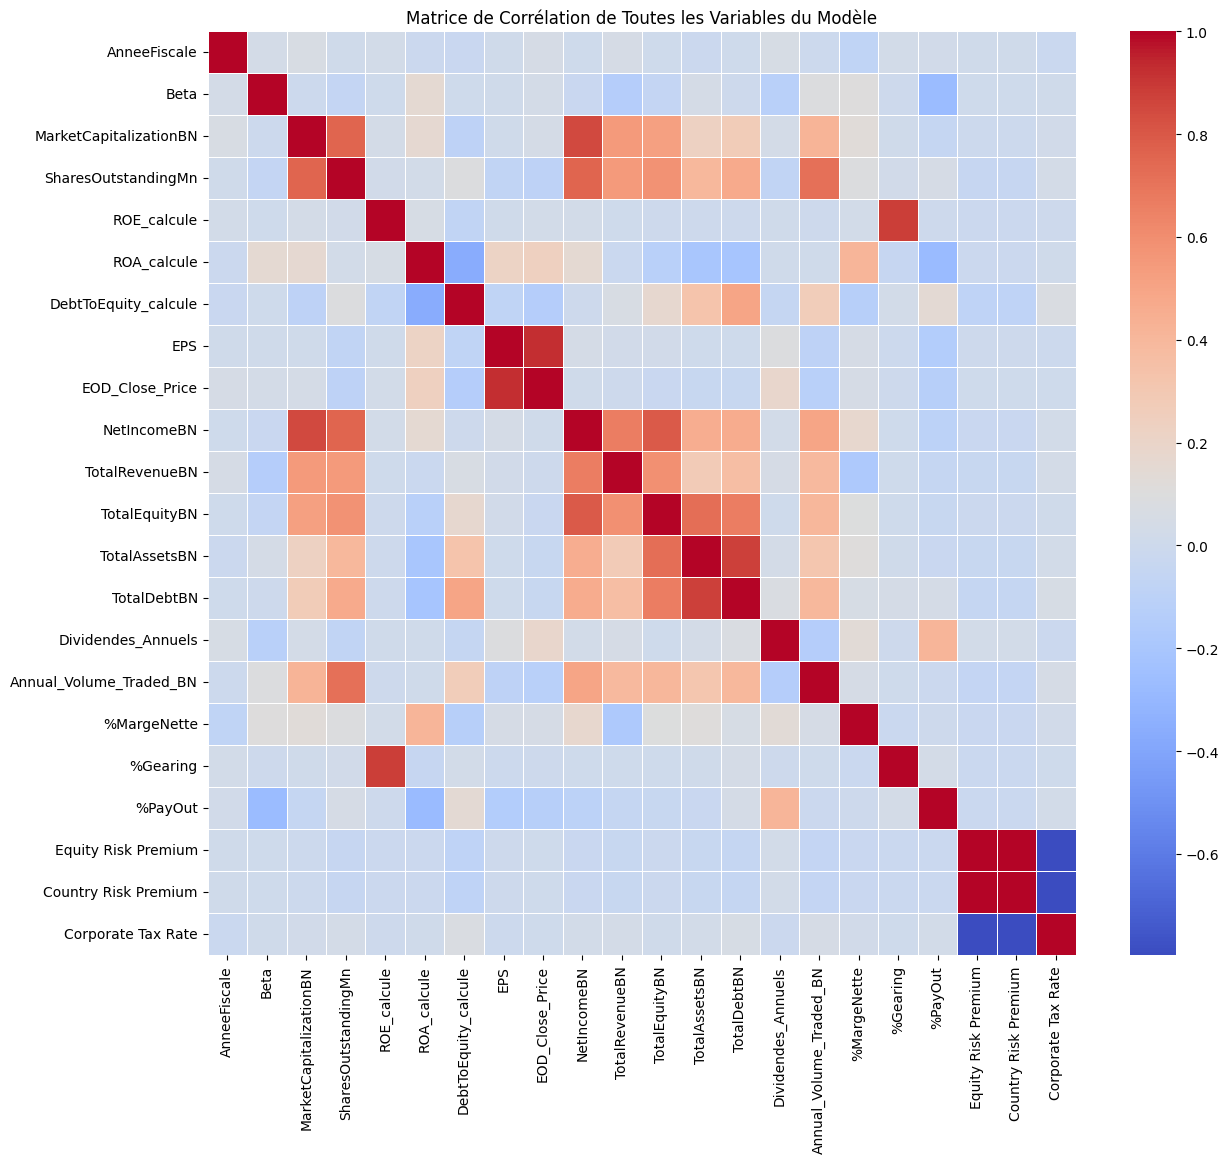

In [53]:
plt.figure(figsize=(14, 12)) 
sns.heatmap(
    matrice_corr_cols, 
    annot=False,  
    cmap='coolwarm', 
    fmt=".2f",
    linewidths=.5
)
plt.title('Matrice de Corrélation de Toutes les Variables du Modèle')
plt.show()

In [50]:
modele_1 = """
PER_calcule ~ Beta +
            MarketCapitalizationBN + 
            SharesOutstandingMn + 
            ROE_calcule + 
            ROA_calcule + 
            DebtToEquity_calcule + 
            EPS+ 
            EOD_Close_Price + 
            NetIncomeBN + 
            TotalRevenueBN + 
            TotalEquityBN + 
            TotalAssetsBN+ 
            TotalDebtBN + 
            Dividendes_Annuels + 
            Annual_Volume_Traded_BN + 
            Q("%MargeNette") + 
            Q("%Gearing") +
            Q("%PayOut") 
"""

modele_1 = smf.ols(formula=modele_1, data=df_fusion).fit()

print("\n--- Résultat de la Régression (Modèle Macro-Financier) ---")
print(modele_1.summary())


--- Résultat de la Régression (Modèle Macro-Financier) ---
                            OLS Regression Results                            
Dep. Variable:            PER_calcule   R-squared:                       0.437
Model:                            OLS   Adj. R-squared:                  0.430
Method:                 Least Squares   F-statistic:                     63.94
Date:                Fri, 19 Dec 2025   Prob (F-statistic):          3.56e-170
Time:                        13:08:05   Log-Likelihood:                -5221.9
No. Observations:                1501   AIC:                         1.048e+04
Df Residuals:                    1482   BIC:                         1.058e+04
Df Model:                          18                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------

Nous remarquons un problème de multicolinéarité. Nous avons déjà testé la corrélation avec la matrice de corrélation donc il faut calculer les VIF (Variation Inflation Factors) 


In [54]:
var_exp = [
    'AnneeFiscale', 'Beta', 'MarketCapitalizationBN',
    'SharesOutstandingMn', 'ROE_calcule', 'ROA_calcule',
    'DebtToEquity_calcule', 'EPS', 'EOD_Close_Price', 'NetIncomeBN',
    'TotalRevenueBN', 'TotalEquityBN', 'TotalAssetsBN', 'TotalDebtBN',
    'Dividendes_Annuels', 'Annual_Volume_Traded_BN', '%MargeNette',
    '%Gearing', '%PayOut'
]

In [56]:
#Création d'une variable X contenant toutes les variables explicatives utilisées dans le modèle
X = df_fusion[var_exp]

# 3. Ajouter une constante (obligatoire pour le calcul du VIF)
X = add_constant(X)

# 4. Calculer le VIF pour chaque variable
vif_data = pd.DataFrame()
vif_data["Variable"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(len(X.columns))]

# 5. Afficher les résultats triés
print(vif_data.sort_values(by="VIF", ascending=False))

                   Variable           VIF
0                     const  3.627894e+06
10              NetIncomeBN  1.245195e+01
9           EOD_Close_Price  8.647035e+00
8                       EPS  8.210015e+00
12            TotalEquityBN  6.691919e+00
14              TotalDebtBN  6.565534e+00
13            TotalAssetsBN  6.362751e+00
3    MarketCapitalizationBN  6.347714e+00
4       SharesOutstandingMn  5.419019e+00
5               ROE_calcule  4.828275e+00
18                 %Gearing  4.815381e+00
16  Annual_Volume_Traded_BN  2.581645e+00
11           TotalRevenueBN  2.389339e+00
7      DebtToEquity_calcule  1.920746e+00
6               ROA_calcule  1.879973e+00
19                  %PayOut  1.611077e+00
15       Dividendes_Annuels  1.559380e+00
17              %MargeNette  1.535138e+00
2                      Beta  1.197173e+00
1              AnneeFiscale  1.036852e+00


On peut tester une autre regression linéaire en retirant les variables ayant une VIF trop élevée (c'est à dire pouvant être expliquées par d'autres variables). Le Net Income à la VIF la plus élevée car il peut être expliqué par une combinaison du revenu et de la marge nette

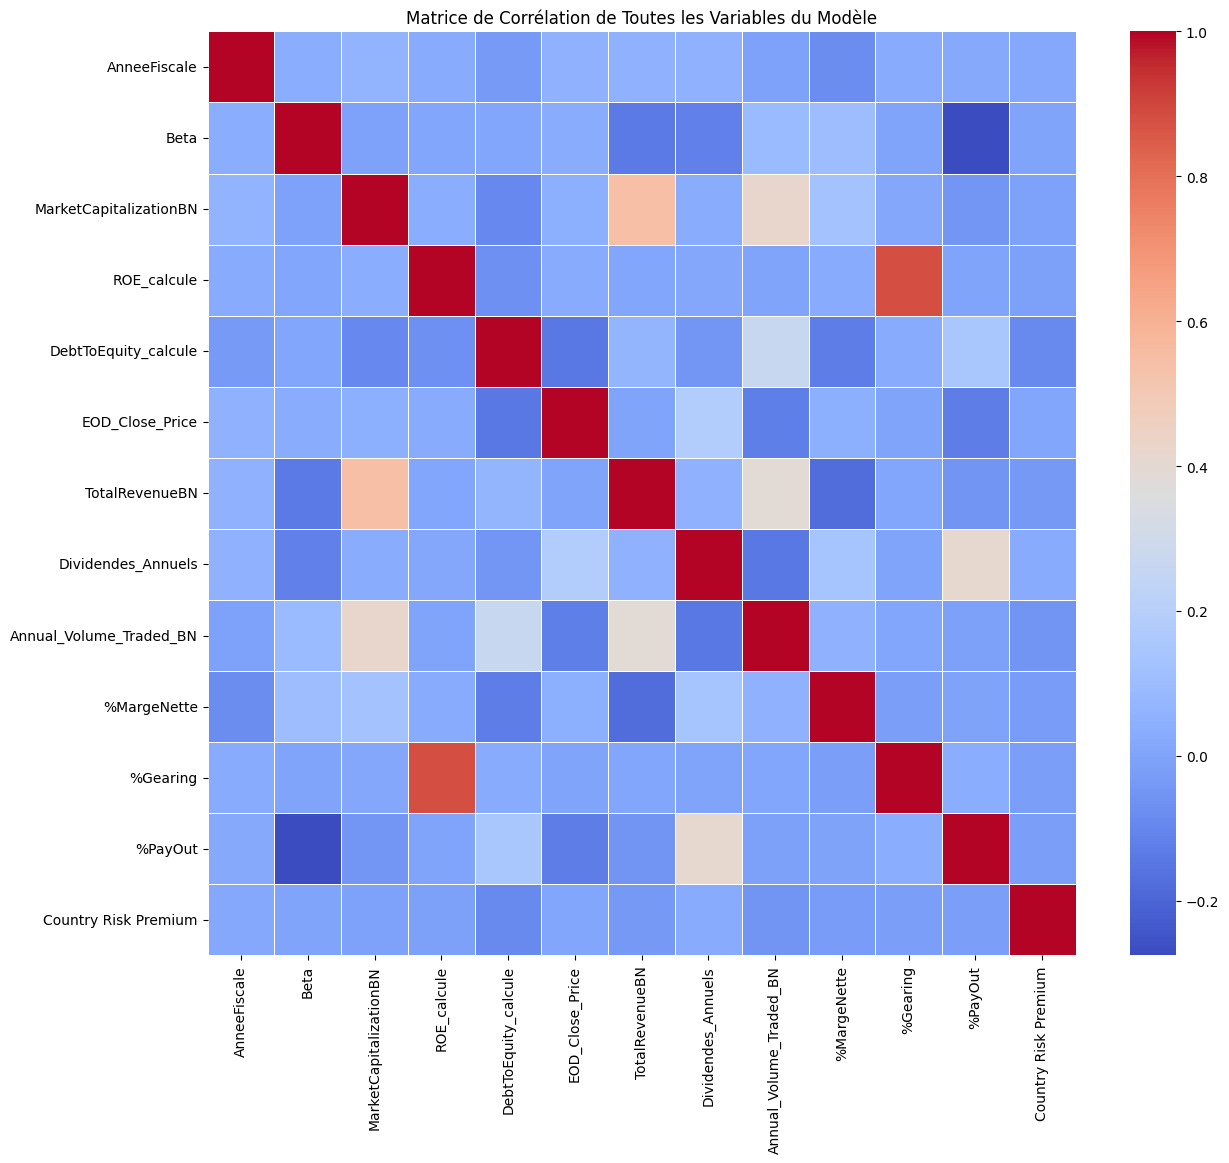

In [58]:
colonnes_finales = ['Beta', 'MarketCapitalizationBN',
    'ROE_calcule', 'DebtToEquity_calcule', 'EOD_Close_Price',
    'TotalRevenueBN', 'Dividendes_Annuels', 'Annual_Volume_Traded_BN', 
    '%MargeNette', '%Gearing', '%PayOut', 'Country Risk Premium'
]

matrice_corr_cols = df_fusion[colonnes_finales].corr()


plt.figure(figsize=(14, 12)) 
sns.heatmap(
    matrice_corr_cols, 
    annot=False,  
    cmap='coolwarm', 
    fmt=".2f",
    linewidths=.5
)
plt.title('Matrice de Corrélation de Toutes les Variables du Modèle')
plt.show()

In [61]:

modele_2 = """
PER_calcule ~ Beta + 
            MarketCapitalizationBN + 
            ROE_calcule + 
            DebtToEquity_calcule +
            EOD_Close_Price +
            TotalRevenueBN + 
            Dividendes_Annuels + 
            Annual_Volume_Traded_BN + 
            Q("%MargeNette") + 
            Q("%PayOut")
"""

modele_2 = smf.ols(formula=modele_2, data=df_fusion).fit()

print("\n--- Résultat de la Régression (Modèle Macro-Financier) ---")
print(modele_2.summary())


--- Résultat de la Régression (Modèle Macro-Financier) ---
                            OLS Regression Results                            
Dep. Variable:            PER_calcule   R-squared:                       0.225
Model:                            OLS   Adj. R-squared:                  0.220
Method:                 Least Squares   F-statistic:                     43.26
Date:                Sat, 20 Dec 2025   Prob (F-statistic):           1.16e-75
Time:                        17:59:38   Log-Likelihood:                -5462.0
No. Observations:                1501   AIC:                         1.095e+04
Df Residuals:                    1490   BIC:                         1.100e+04
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------

On remarque que le R^2 est inférieur donc les variables utilisées expliquent moins la variable prédite, PER_calcule, même si l'on parvient à réduire le problème de multicollinéarité 